# 基于 AlexNet 的 FashionMNIST 数据集的分类
## 1. 导入 FashionMNIST 数据集
首先我们下载 FashionMNIST， 这需要定义一个导入函数 load_FashionMNIST_dataset 和类别标签函数 get_FashionMNIST_label

In [1]:
import numpy as np
#imports

import torch
from torch import nn
from torch import optim
from torch.utils import data
import torch.functional as F

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("./runs/FashionMNIST/AlexNet")

import torchvision
from torchvision import transforms

import numpy
import matplotlib.pyplot as plt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

ROOT = "./data"
def load_FashionMNIST_dataset(batch_size, root=ROOT):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize(0.5,0.5),
    ])

    trainset = torchvision.datasets.FashionMNIST(root,train=True,transform=transform,download=True)
    testset = torchvision.datasets.FashionMNIST(root,train=False,transform=transform,download=True)

    trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False,num_workers=2)

    return trainloader, testloader

labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']


下面定义一个打印图片的函数 imshow()

In [2]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))


我们设置批量大小为 64，下面我门随机打印几张图片观察一下

['t-shirt', 't-shirt', 'trouser', 't-shirt', 'dress', 'sandal', 'sneaker', 'coat', 'trouser', 'bag', 'dress', 'pullover', 'trouser', 'sneaker', 'pullover', 'sneaker', 'ankle boot', 'coat', 'sandal', 'sneaker', 'bag', 'dress', 'ankle boot', 'pullover', 'pullover', 'dress', 'coat', 'coat', 'sneaker', 'dress', 't-shirt', 'dress', 'ankle boot', 'coat', 'ankle boot', 'pullover', 'pullover', 'pullover', 'sneaker', 'pullover', 'ankle boot', 'trouser', 'ankle boot', 'bag', 'shirt', 'shirt', 'shirt', 'coat', 'coat', 'bag', 'sandal', 'sandal', 'shirt', 'shirt', 'pullover', 'bag', 'trouser', 'bag', 'sneaker', 'sneaker', 't-shirt', 'coat', 'coat', 'coat', 'pullover', 'coat', 'shirt', 'pullover', 'bag', 'sandal', 'pullover', 'shirt', 'pullover', 'coat', 'sandal', 'pullover', 'shirt', 'bag', 'sandal', 'pullover', 'sandal', 'bag', 't-shirt', 'dress', 'pullover', 'dress', 'shirt', 'trouser', 'pullover', 'pullover', 't-shirt', 'ankle boot', 'sandal', 'shirt', 'coat', 'coat', 'ankle boot', 'shirt', 'shi

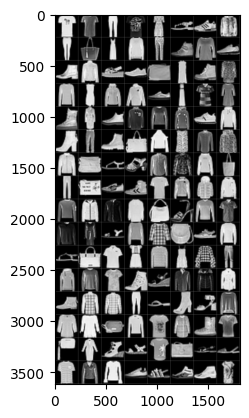

In [3]:
BatchSize = 128

trains, tests = load_FashionMNIST_dataset(batch_size=BatchSize)

trainiter = iter(trains)
X, y = next(trainiter)

img_grid = torchvision.utils.make_grid(X)
imshow(img_grid)
print([labels[idx] for idx in y])

writer.add_images("Some Samples",X)
writer.close()

## 2.AlexNet

### 基本架构：
AlexNet 于 LeNet 的结构很相似，但是输入参数的数量与网络深度都比 LeNet 高很多，其基本结构如下：

输入：图片（$3\times 224\times 224$）
- $11\times 11$ 卷积层（96），步幅为 4 （96@54*54）
- ReLU 函数激活
- $3\times 3$ 最大汇聚层，步幅为 2 （96@26*26）
- $5\times 5$ 卷积层（256），填充为 2 （256@26*26）
- ReLU 函数激活
- $3\times 3$ 最大汇聚层，步幅为 2 （256@12*12）
- $3\times 3$ 卷积层（384），填充为 1 （384@12*12）
- ReLU 函数激活
- $3\times 3$ 卷积层（384），填充为 1 （384@12*12）
- ReLU 函数激活
- $3\times 3$ 卷积层（256），填充为 1 （256@12*12）
- ReLU 函数激活
- $3\times 3$ 最大汇聚层，步幅为 2 （256@5*5）
- Flatten 展平
- 全连接层（256\*5*5,4096）
- ReLU 函数激活
- Dropout(0.5)
- 全连接层（4096，4096）
- ReLU 函数激活
- Dropout(0.5)
- 全连接层（4096，1000）
- softmax 函数分类输出

输出：1000 个类别样本

### 创新特点
1. 激活函数使用 ReLU 函数，有效避免了饱和，使得训练更容易。
2. 使用了暂退法（dropout），控制全连接层的复杂度。
3. 在训练时增加了大量的图像增强数据，如翻转、裁切和变色。 使得模型更健壮，更大的样本量有效地减少了过拟合。
4. 模型层数加深。

In [4]:
alexnet = nn.Sequential(
    nn.Conv2d(1,96,kernel_size=11,stride=4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96,256,kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Conv2d(256,384,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.Conv2d(384,384,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.Conv2d(384,256,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Flatten(),
    nn.Linear(256*5*5,4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096,10)
)

writer.add_graph(alexnet,X)
writer.close()

In [7]:
def train(epochs, model, criterion, opt,train_set):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    model.apply(init_weights)
    print("Training on!")

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device("cpu")

    model.to(device)

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for i,(X, y) in enumerate(train_set,0):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"epoch {i}: loss={running_loss}")
        running_loss = 0
    print("Finish Training")
    return model.eval()

epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr = 0.001, momentum=0.9)
model = train(epochs,alexnet,criterion,optimizer,trains)

Training on!


In [ ]:
def accuracy(model, dataset):
    total = 0
    correct = 0
    with torch.no_grad():
        for _,(X,y) in enumerate(dataset):
            outputs = model(X)
            _,preds = torch.max(outputs, 1) 
            total += y.size(0)
            correct += (y==preds).sum().item()
    return correct/total


model.cpu()
print("Accuracy of train sets:", accuracy(model, trains))
print("Accuracy of test sets:", accuracy(model, tests))

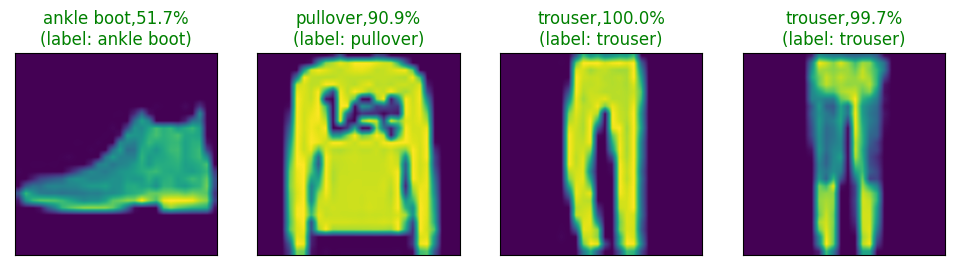

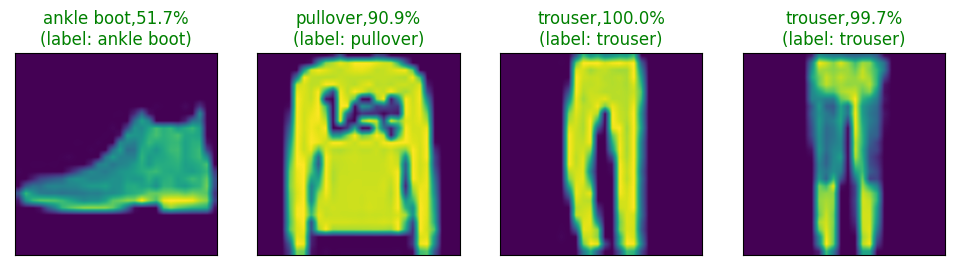

In [11]:
def pred_to_probs(net, X):
    output = net(X)
    _,preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [torch.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_class_preds(net, X, y):
    preds, probs = pred_to_probs(net, X)
    fig = plt.figure(figsize=(12,48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1,4, idx+1, xticks=[], yticks=[])
        imshow(X[idx])
        ax.set_title("{0},{1:.1f}%\n(label: {2})".format(
            labels[preds[idx]],
            probs[idx]*100,
            labels[y[idx]]),
            color = ("green" if preds[idx] == y[idx].item() else "red"))
    return fig

testiter = iter(tests)
X, y = next(testiter)
plot_class_preds(model,X, y)

In [12]:
class_probs = []
class_preds = []
with torch.no_grad():
    for data in tests:
        X, y = data
        output = model(X)
        class_probs_batch = [torch.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)


def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(labels[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

for i in range(len(labels)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)